In [1]:
# Загрузка DATA с яндекс облака

import requests
import zipfile
import os
from tqdm.auto import tqdm

PUBLIC_LINK = "https://disk.yandex.ru/d/kz9g5msVqtahiw"  
ZIP_FILE_NAME = 'nutrition.zip'
DATA_DIR = './data'


def download_file_from_yandex_disk(public_link, destination_path):
    """Загружает файл с Яндекс.Диска по публичной ссылке с progress bar."""
    
    api_url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={public_link}"
    
    try:
        response = requests.get(api_url)
        response.raise_for_status()
        download_url = response.json()['href']
    except requests.RequestException as e:
        print(f"Ошибка получения ссылки для скачивания: {e}")
        return

    try:
        with requests.get(download_url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            
            with open(destination_path, 'wb') as f, tqdm(
                desc=destination_path,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    size = f.write(chunk)
                    bar.update(size)
        print(f"Файл '{destination_path}' успешно загружен.")
        return True
    except requests.RequestException as e:
        print(f"Ошибка при скачивании файла: {e}")
        return False


if os.path.exists(DATA_DIR) and os.path.exists(os.path.join(DATA_DIR, 'dish.csv')):
    print(f"Папка '{DATA_DIR}' уже существует и содержит данные. Пропускаем загрузку и распаковку.")
else:
    print("Начинаю загрузку архива с Яндекс.Диска...")
    if download_file_from_yandex_disk(PUBLIC_LINK, ZIP_FILE_NAME):
        
        if not os.path.exists(DATA_DIR):
            os.makedirs(DATA_DIR)
            
        print(f"\nНачинаю распаковку '{ZIP_FILE_NAME}' в папку '{DATA_DIR}'...")
        try:
            with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
                zip_ref.extractall(DATA_DIR)
            print("Архив успешно распакован.")
            
            os.remove(ZIP_FILE_NAME)
            print(f"Файл '{ZIP_FILE_NAME}' удален.")
            
        except zipfile.BadZipFile:
            print(f"Ошибка: файл '{ZIP_FILE_NAME}' не является корректным zip-архивом.")
            
    print("\nПодготовка данных завершена!")

Папка './data' уже существует и содержит данные. Пропускаем загрузку и распаковку.


/home/ubuntu/food_calories-1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random

DATA_DIR = './data'

# EDA

In [3]:
# Загрузка CSV файлов 
path_dish = os.path.join(DATA_DIR, 'dish.csv')
path_ingredients = os.path.join(DATA_DIR, 'ingredients.csv')

df_dish = pd.read_csv(path_dish)
df_ingredients = pd.read_csv(path_ingredients)

print("--- Таблица с блюдами (dish.csv) ---")
df_dish.info()
print(df_dish.head())

print("\n--- Таблица с ингредиентами (ingredients.csv) ---")
df_ingredients.info()
print(df_ingredients.head())

--- Таблица с блюдами (dish.csv) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.5+ KB
           dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2

count    3262.000000
mean      255.012738
std       219.637570
min         0.000000
25%        80.114996
50%       209.110062
75%       375.122963
max      3943.325195
Name: total_calories, dtype: float64


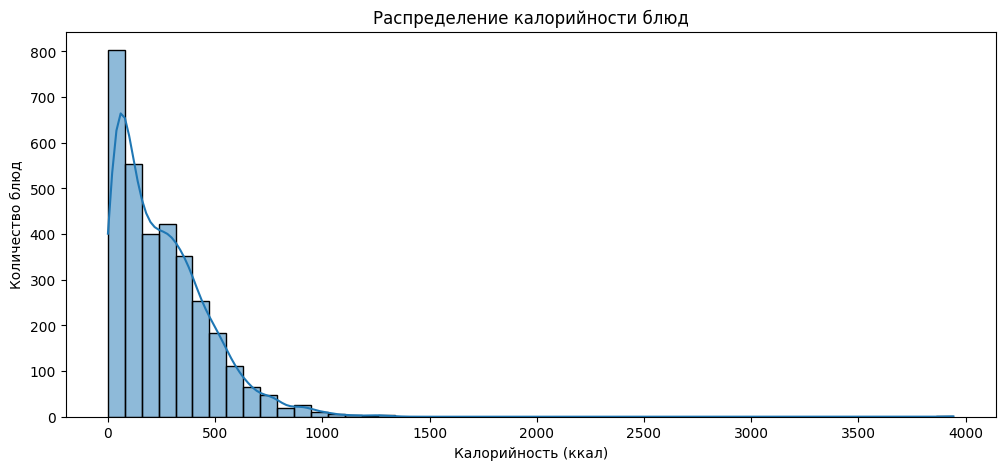

In [4]:
#  Анализ целевой переменной `total_calories` 
print(df_dish['total_calories'].describe())

plt.figure(figsize=(12, 5))
sns.histplot(df_dish['total_calories'], bins=50, kde=True)
plt.title('Распределение калорийности блюд')
plt.xlabel('Калорийность (ккал)')
plt.ylabel('Количество блюд')
plt.show()

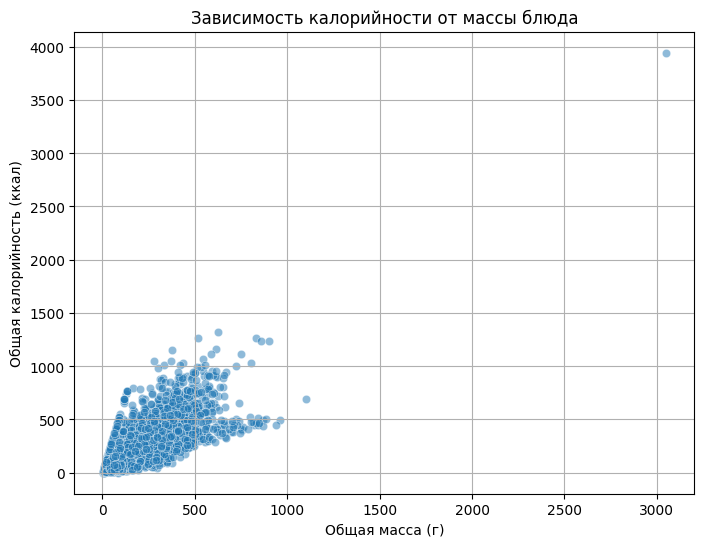

Коэффициент корреляции между массой и калорийностью: 0.76


In [5]:
# Анализ связи между массой и калорийностью 
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_dish, x='total_mass', y='total_calories', alpha=0.5)
plt.title('Зависимость калорийности от массы блюда')
plt.xlabel('Общая масса (г)')
plt.ylabel('Общая калорийность (ккал)')
plt.grid(True)
plt.show()

correlation = df_dish['total_mass'].corr(df_dish['total_calories'])
print(f"Коэффициент корреляции между массой и калорийностью: {correlation:.2f}")



count    3262.000000
mean        7.313305
std         6.943276
min         1.000000
25%         1.000000
50%         4.000000
75%        12.000000
max        34.000000
Name: ingredient_count, dtype: float64


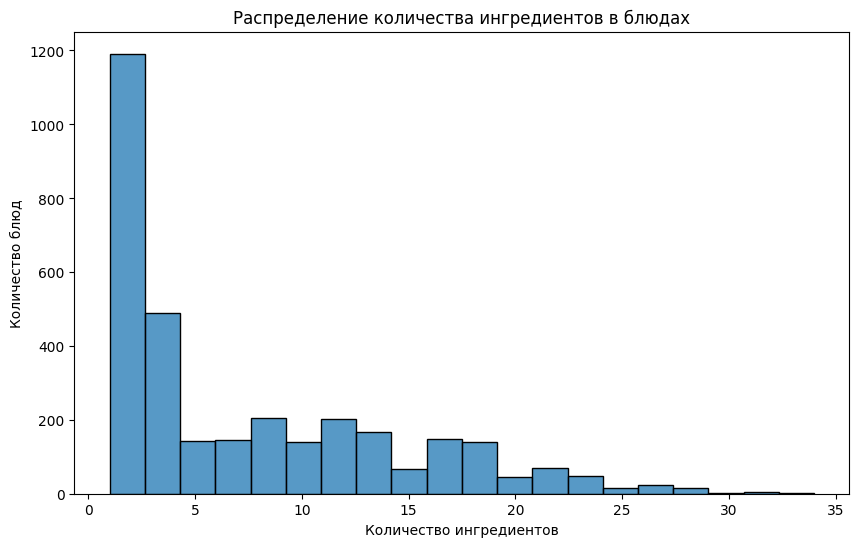

In [6]:
#  Анализ количества ингредиентов 
df_dish['ingredient_count'] = df_dish['ingredients'].apply(lambda s: len(s.split(';')))

print(df_dish['ingredient_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df_dish['ingredient_count'], bins=20, kde=False)
plt.title('Распределение количества ингредиентов в блюдах')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Количество блюд')
plt.show()

--- 5 случайных изображений из датасета ---


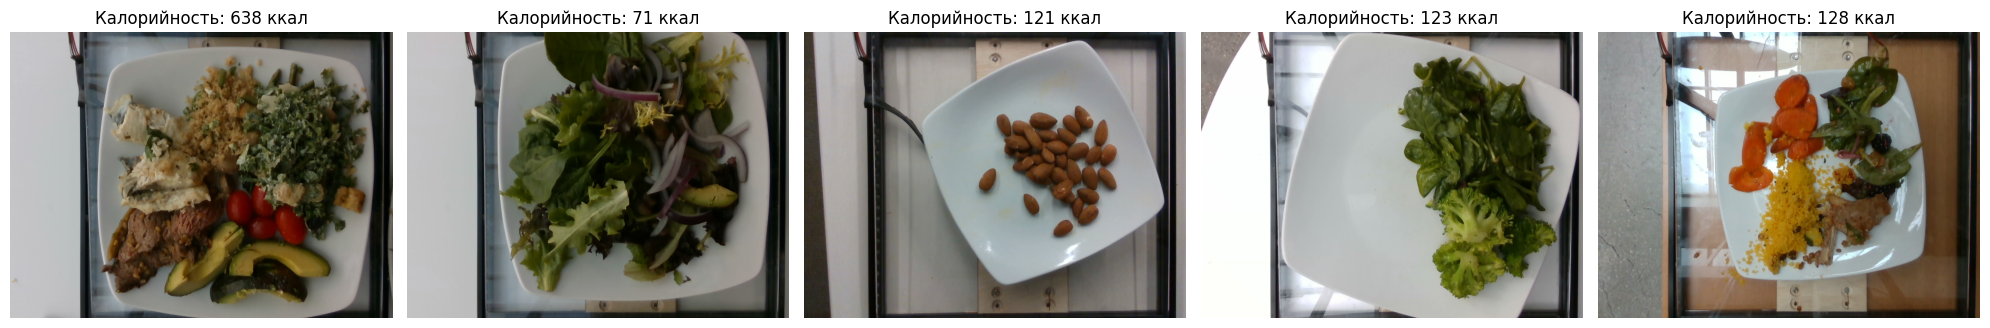

In [7]:
# Визуальный анализ изображений 
print("--- 5 случайных изображений из датасета ---")

images_dir = os.path.join(DATA_DIR, 'images')
all_dish_ids = df_dish['dish_id'].tolist()
random_dish_ids = random.sample(all_dish_ids, 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, dish_id in enumerate(random_dish_ids):
    image_path = os.path.join(images_dir, dish_id, 'rgb.png')
    
    try:
        img = Image.open(image_path)
        calories = df_dish[df_dish['dish_id'] == dish_id].iloc[0]['total_calories']
        
        axes[i].imshow(img)
        axes[i].set_title(f"Калорийность: {calories:.0f} ккал")
        axes[i].axis('off')

    except FileNotFoundError:
        axes[i].set_title(f"Изображение\nне найдено")
        axes[i].axis('off')

plt.tight_layout()
plt.show()

### Выводы по EDA и выбор подхода

Анализ показал сильную корреляцию массы с калорийностью и важность ингредиентного состава. Выбран подход мультимодальной нейросети, сочетающей визуальные и текстовые признаки.

# Обучение

In [8]:
# Запуск обучения лучшей модели (EfficientNet-B0)
import config
from scripts.utils import train_model

print("--- НАСТРОЙКИ ОБУЧЕНИЯ ---")
print(f"Устройство: {config.DEVICE}")
print(f"Image Model: {config.IMAGE_MODEL_NAME}")
print(f"Количество эпох: {config.EPOCHS}")
print(f"Размер батча: {config.BATCH_SIZE}")
print("--------------------------\n")

train_model(config)

--- НАСТРОЙКИ ОБУЧЕНИЯ ---
Устройство: cuda
Image Model: tf_efficientnet_b0
Количество эпох: 25
Размер батча: 32
--------------------------

Обучение будет на устройстве: cuda


/home/ubuntu/food_calories-1/scripts/dataset.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=int(0.1 * input_size[0]), max_width=int(0.1 * input_size[1]), p=0.5),



--- Эпоха 1 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.90it/s]


Средняя MAE на обучении: 117.35


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


MAE на тесте: 93.43
Новая лучшая модель сохранена! MAE = 93.43

--- Эпоха 2 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.95it/s]


Средняя MAE на обучении: 87.40


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]


MAE на тесте: 72.43
Новая лучшая модель сохранена! MAE = 72.43

--- Эпоха 3 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.03it/s]


Средняя MAE на обучении: 77.98


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]


MAE на тесте: 60.01
Новая лучшая модель сохранена! MAE = 60.01

--- Эпоха 4 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.01it/s]


Средняя MAE на обучении: 73.07


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]


MAE на тесте: 77.86

--- Эпоха 5 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.03it/s]


Средняя MAE на обучении: 70.99


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.24it/s]


MAE на тесте: 69.27

--- Эпоха 6 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.94it/s]


Средняя MAE на обучении: 69.26


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.26it/s]


MAE на тесте: 60.03

--- Эпоха 7 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Средняя MAE на обучении: 64.22


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]


MAE на тесте: 61.73

--- Эпоха 8 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.96it/s]


Средняя MAE на обучении: 65.36


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]


MAE на тесте: 59.00
Новая лучшая модель сохранена! MAE = 59.00

--- Эпоха 9 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.03it/s]


Средняя MAE на обучении: 57.73


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.23it/s]


MAE на тесте: 57.91
Новая лучшая модель сохранена! MAE = 57.91

--- Эпоха 10 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.98it/s]


Средняя MAE на обучении: 60.34


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]


MAE на тесте: 58.41

--- Эпоха 11 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.04it/s]


Средняя MAE на обучении: 58.82


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]


MAE на тесте: 58.86

--- Эпоха 12 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.08it/s]


Средняя MAE на обучении: 57.39


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


MAE на тесте: 57.59
Новая лучшая модель сохранена! MAE = 57.59

--- Эпоха 13 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.97it/s]


Средняя MAE на обучении: 58.22


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]


MAE на тесте: 57.46
Новая лучшая модель сохранена! MAE = 57.46

--- Эпоха 14 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.95it/s]


Средняя MAE на обучении: 58.15


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.23it/s]


MAE на тесте: 58.29

--- Эпоха 15 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.09it/s]


Средняя MAE на обучении: 57.34


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]


MAE на тесте: 56.29
Новая лучшая модель сохранена! MAE = 56.29

--- Эпоха 16 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.04it/s]


Средняя MAE на обучении: 56.86


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]


MAE на тесте: 58.31

--- Эпоха 17 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.08it/s]


Средняя MAE на обучении: 56.75


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


MAE на тесте: 57.05

--- Эпоха 18 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.06it/s]


Средняя MAE на обучении: 56.20


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]


MAE на тесте: 57.98

--- Эпоха 19 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.99it/s]


Средняя MAE на обучении: 56.32


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


MAE на тесте: 60.23

--- Эпоха 20 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.00it/s]


Средняя MAE на обучении: 56.52


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]


MAE на тесте: 57.86

--- Эпоха 21 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Средняя MAE на обучении: 55.76


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]


MAE на тесте: 60.30

--- Эпоха 22 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.90it/s]


Средняя MAE на обучении: 57.10


Оценка: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]


MAE на тесте: 61.37

--- Эпоха 23 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


Средняя MAE на обучении: 54.59


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.07it/s]


MAE на тесте: 59.10

--- Эпоха 24 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.90it/s]


Средняя MAE на обучении: 56.56


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]


MAE на тесте: 57.95

--- Эпоха 25 / 25 ---


Обучение: 100%|██████████| 87/87 [00:17<00:00,  4.96it/s]


Средняя MAE на обучении: 57.16


Оценка: 100%|██████████| 16/16 [00:03<00:00,  5.22it/s]

MAE на тесте: 60.04

Обучение завершено!
Лучший результат MAE на тесте: 56.29


--- Финальный анализ лучшей модели (EfficientNet-B0) ---
Используется модель: ./best_model_efficientnet_finetuned.pth


Финальная оценка: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]



Итоговая MAE лучшей модели: 56.38

Топ-5 блюд с наибольшей ошибкой:
             dish_id  predicted_calories  actual_calories  absolute_error
88   dish_1563478751          527.376038       950.395081      423.019043
141  dish_1565811139          497.716949       902.200012      404.483063
170  dish_1566501594          128.227798       508.048981      379.821167
423  dish_1563984296          722.516785       436.337067      286.179718
302  dish_1565030391          348.902771       609.333923      260.431152


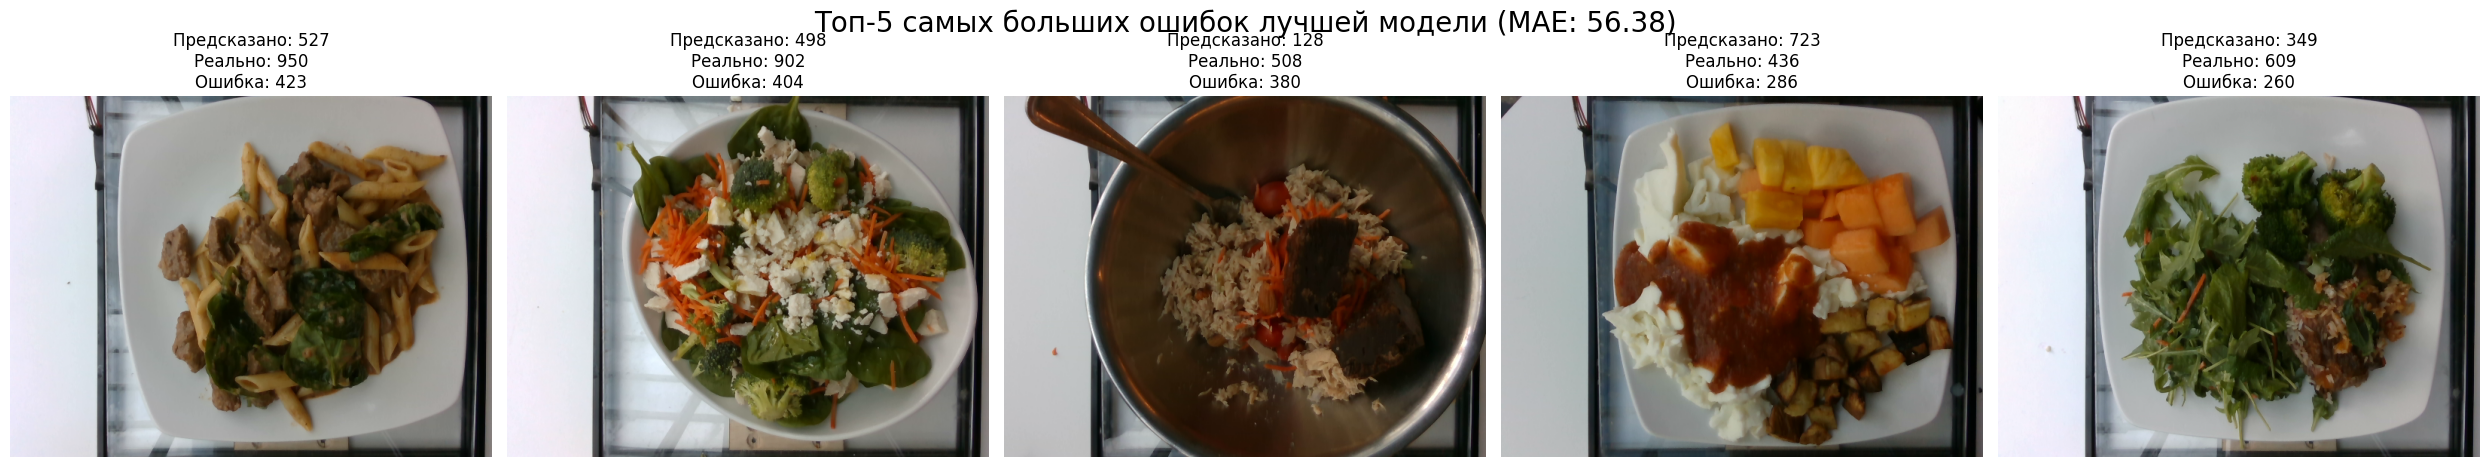

In [10]:
# Финальный анализ лучшей модели
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import config 
from scripts.dataset import FoodDataset, collate_fn
from scripts.model import CaloriePredictor

print("--- Финальный анализ лучшей модели (EfficientNet-B0) ---")

BEST_MODEL_PATH = './best_model_efficientnet_finetuned.pth'
print(f"Используется модель: {BEST_MODEL_PATH}")

test_dataset = FoodDataset(config, split='test')
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)

model = CaloriePredictor(config, num_ingredients=test_dataset.num_ingredients).to(config.DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

all_predictions = []
all_actuals = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Финальная оценка"):
        images, ingredients, mass = batch['image'].to(config.DEVICE), batch['ingredients'].to(config.DEVICE), batch['mass'].to(config.DEVICE)
        predictions = model(images, ingredients, mass)
        all_predictions.extend(predictions.cpu().numpy().flatten())
        all_actuals.extend(batch['calories'].numpy().flatten())

results_df = pd.DataFrame({'dish_id': test_dataset.data['dish_id'].tolist(), 'predicted_calories': all_predictions, 'actual_calories': all_actuals})
results_df['absolute_error'] = np.abs(results_df['predicted_calories'] - results_df['actual_calories'])
final_mae = results_df['absolute_error'].mean()

print(f"\n" + "="*50)
print(f"Итоговая MAE лучшей модели: {final_mae:.2f}")
print("="*50)

top_5_errors = results_df.sort_values(by='absolute_error', ascending=False).head(5)
print("\nТоп-5 блюд с наибольшей ошибкой:")
print(top_5_errors)

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('Топ-5 самых больших ошибок лучшей модели (MAE: {:.2f})'.format(final_mae), fontsize=20)
for i, row in enumerate(top_5_errors.itertuples()):
    dish_id, pred_cal, actual_cal, error = row.dish_id, row.predicted_calories, row.actual_calories, row.absolute_error
    image_path = os.path.join(config.DATA_DIR, 'images', dish_id, 'rgb.png')
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Предсказано: {pred_cal:.0f}\nРеально: {actual_cal:.0f}\nОшибка: {error:.0f}", fontsize=12)
    axes[i].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Общий вывод по ошибкам:** Модель хорошо справляется со стандартными блюдами, но испытывает трудности, когда визуальное представление обманчиво. Возможно из-за того, что ингриденты в блюдах сильно перемешаны. Для дальнейшего улучшения качества необходимо либо значительно расширять датасет, либо обогащать его более детальными данными о составе.